In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2019 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
coalLikelihood :: R->(Z,RVec,RVec)->P RVec
coalLikelihood t (n,s,g) = do
  let rate y = g!(findSortedInsertIndex y s)
      widths = vector
        [ (s!(i+1)) - (s!i)
        | i <- 1...(n-1) ] :: RVec
      w = blockVector [cast (s!1), widths,
        cast (t - (s!n))] :: RVec
      areas = vector [ (w!j) * (g!j)
                     | j <- 1...(n+1) ]
      area = sum' areas
  y <- poissonProcess t rate area
  return y

coalPrior :: R -> P (Z,RVec,RVec)
coalPrior t = do
  let lam = 3; nMax = 30; a = 1; b = 200
  n <- truncated 1 nMax (poisson lam)
  s' <- orderedSample
         (2*n + 1) (uniform 0 t) :: P RVec
  let s = vector [ s'!(2*i) | i <- 1...n ]
  g <- joint vector [ gamma a b
                    | _ <- 1...(n+1) ]
  return (n,s,g)

type Model = (Z,RVec,RVec,RVec)
coal :: R -> P Model
coal t = do
  (n,s,g) <- coalPrior t
  y <- coalLikelihood t (n,s,g)
  return (n,s,g,y)

In [3]:
coalMovePoint :: R -> Model -> P Model
coalMovePoint t (n,s_,g,y) = do
  let s i = if i == 0 then 0
       else if i == (n+1) then t
       else (s_!i)
  j <- uniform 1 n
  u <- uniform 0 1
  let sj' = s (j-1) +
           (s (j+1) - s (j-1)) * u
      s' = s_ `replaceAt` (j, sj')
  return (n,s',g,y)

coalMoveRate :: R -> Model -> P Model
coalMoveRate t (n,s,g,y) = do
  j <- uniform 1 (n+1)
  u <- uniform (-1/2) (1/2)
  let gj = exp (log (g!j) + u)
      g' = g `replaceAt` (j, gj)
  return (n,s,g',y)

coalMoveBirth :: R -> Model -> P Model
coalMoveBirth t (n,s,g,y) = do
  x <- uniform 0 t
  let j = findSortedInsertIndex x s
      s' = s `insertAt` (j, x)
  u <- lognormal 0 1
  let g' = g `insertAt` (j+1, u * (g!j))
  return (n+1,s',g',y)

coalMoveDeath :: R -> Model -> P Model
coalMoveDeath t (n,s,g,y) = do
  j <- uniform 1 n
  let s' = s `deleteAt` j
      g' = g `deleteAt` (j+1)
  return (n-1,s',g',y)

In [4]:
coalMoveProbs :: Z -> (R,R,R,R)
coalMoveProbs n = (e,p,b,d)
  where lam = 3
        nMax = 30
        c = 0.9 * (real lam + 1) / (2 * real lam + 1)
        b = if n == nMax then 0 else if n < (lam - 1) then c else c * real lam / (cast n + 1) :: R
        d = if n == 1    then 0 else if lam < n       then c else c * cast n / real lam :: R
        p = if n == 1 then 0     else (1-b-d)/2 :: R
        e = if n == 1 then 1-b-d else (1-b-d)/2 :: R

In [5]:
coalMove :: R -> Model -> P Model
coalMove t m@(n,_,_,_) = do
  let (e,p,b,d) = coalMoveProbs n
  mixture' [(e, coalMoveRate  t m)
           ,(p, coalMovePoint t m)
           ,(b, coalMoveBirth t m)
           ,(d, coalMoveDeath t m) ]

coalStep :: R -> Model -> IO Model
coalStep t m =
  coal t `rjmc` coalMove t `runStep` m

In [6]:
coalData = [ 1851.203, 1851.632, 1851.969, 1851.975, 1852.314, 1852.347, 1852.358, 1852.385, 1852.977 , 1853.196, 1853.229, 1853.319, 1853.500, 1854.135, 1856.396, 1856.506, 1856.539, 1856.618 , 1857.138, 1857.404, 1857.582, 1858.091, 1858.154, 1858.406, 1858.945, 1860.125, 1860.169 , 1860.591, 1860.851, 1860.919, 1860.971, 1861.185, 1861.738, 1861.836, 1862.138, 1862.893 , 1862.937, 1863.178, 1863.794, 1863.939, 1863.986, 1865.459, 1865.971, 1866.064, 1866.340 , 1866.452, 1866.833, 1866.948, 1866.951, 1867.635, 1867.854, 1867.862, 1868.749, 1868.903 , 1868.988, 1869.251, 1869.442, 1869.554, 1869.809, 1869.875, 1870.124, 1870.515, 1870.559 , 1870.633, 1871.027, 1871.151, 1871.167, 1871.736, 1871.816, 1872.123, 1872.240, 1872.769 , 1873.136, 1874.285, 1874.546, 1874.888, 1874.981, 1875.329, 1875.925, 1875.931, 1875.931 , 1876.966, 1877.064, 1877.105, 1877.190, 1877.779, 1877.809, 1878.184, 1878.195, 1878.236 , 1878.433, 1878.696, 1879.036, 1879.172, 1879.501, 1880.057, 1880.539, 1880.689, 1880.944 , 1881.105, 1881.968, 1882.129, 1882.296, 1882.299, 1882.335, 1882.852, 1883.797, 1883.851 , 1884.073, 1884.856, 1885.168, 1885.464, 1885.979, 1886.617, 1886.693, 1886.754, 1886.921 , 1887.134, 1887.405, 1888.298, 1889.051, 1889.198, 1889.793, 1890.102, 1890.190, 1891.252 , 1891.665, 1892.654, 1893.508, 1894.477, 1895.318, 1896.070, 1896.284, 1896.331, 1899.630 , 1901.393, 1902.671, 1905.056, 1905.188, 1905.524, 1906.773, 1908.136, 1908.270, 1908.629 , 1909.127, 1909.825, 1910.357, 1910.970, 1912.520, 1913.784, 1914.409, 1916.615, 1918.031 , 1922.529, 1922.677, 1923.569, 1927.162, 1928.114, 1930.154, 1930.748, 1931.077, 1931.830 , 1931.884, 1932.065, 1932.864, 1932.875, 1933.883, 1934.723, 1935.643, 1935.695, 1936.596 , 1937.500, 1938.354, 1939.821, 1940.218, 1940.424, 1941.420, 1941.522, 1941.574, 1942.001 , 1942.129, 1942.483, 1946.945, 1947.025, 1947.619, 1947.638, 1947.687, 1951.405, 1957.883 , 1960.489, 1962.220]

In [7]:
coalData' = subtract (head days) <$> days
  where days = [365.2425 * yr | yr <- coalData]

In [8]:
let t = 40907
(n0,s0,g0) <- simulate (coalPrior t)
print (n0,s0,g0)

(3,[21559.815975945814,22129.409240984372,26196.519027965624],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3,4.555065487520266e-4])

In [9]:
-- automatically generate RJMC transition kernel
let kernel = coal t `rjmc` coalMove t
kernel

\input ->
  let v_0_0 = 1 == input.0_0 :: B
      v_0_1 = 30 == input.0_0 :: B
      v_0_2 = input.0_0 < 2 :: B
      v_0_3 = 1.0 + 3.0 :: R
      v_0_4 = 0.9 * v_0_3 :: R
      v_0_5 = 1.0 + 6.0 :: R
      v_0_6 = v_0_4 / v_0_5 :: R
      v_0_7 = v_0_6 * 3.0 :: R
      v_0_8 = 1.0 + input.0_0 :: R
      v_0_9 = v_0_7 / v_0_8 :: R
      v_0_10 = ifThenElse v_0_2 v_0_6 v_0_9 :: R
      v_0_11 = ifThenElse v_0_1 0.0 v_0_10 :: R
      v_0_12 = 1.0 - v_0_11 :: R
      v_0_13 = 3 < input.0_0 :: B
      v_0_14 = v_0_6 * input.0_0 :: R
      v_0_15 = v_0_14 / 3.0 :: R
      v_0_16 = ifThenElse v_0_13 v_0_6 v_0_15 :: R
      v_0_17 = ifThenElse v_0_0 0.0 v_0_16 :: R
      v_0_18 = v_0_12 - v_0_17 :: R
      v_0_19 = v_0_18 / 2.0 :: R
      v_0_20 = ifThenElse v_0_0 v_0_18 v_0_19 :: R
      v_0_21 = ifThenElse v_0_0 0.0 v_0_19 :: R
      v_0_22 = +s 1 1 1 1 :: Z
      v_0_23 = getExternal x_show_0_0 :: Z
      v_0_24 = 1 + input.0_0 :: Z
      v_0_25 = getExternal x_show_0_1 :: Z
      v_0_26 =

In [10]:
samples <- iterateLimit 10 (runStep kernel) (n0,s0,g0, list coalData')
[(n,s,g) | (n,s,g,y) <- samples]

[(3,[21559.815975945814,22129.409240984372,26196.519027965624],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3,4.555065487520266e-4]),(2,[21559.815975945814,22129.409240984372],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3]),(2,[21559.815975945814,22129.409240984372],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3]),(2,[21559.815975945814,22129.409240984372],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3]),(2,[21559.815975945814,22129.409240984372],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3]),(3,[21559.815975945814,22129.409240984372,29165.588722883644],[1.7456145559627975e-2,4.848278504554397e-3,4.654923054877004e-3,1.448490226257338e-3]),(2,[21559.815975945814,29165.588722883644],[1.7456145559627975e-2,4.848278504554397e-3,1.448490226257338e-3]),(2,[21559.815975945814,29165.588722883644],[1.7456145559627975e-2,4.848278504554397e-3,1.448490226257338e-3]),(2,[21559.815975945814,29165.5887228836

In [11]:
-- sampling takes a long time, so we generate samples offline
import System.IO
output <- readFile "rj-coal.log" -- from stochaskell/app/rj
let samples = read <$> lines output :: [(Int,[Double],[Double])]

In [12]:
take 10 samples

[(3,[24969.58172348803,26526.26524169898,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,4.5984983765520634e-4,2.641155121557546e-3]),(3,[24969.58172348803,26526.26524169898,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,5.601448084736443e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.3475125679093145e-4,2.641155121557546e-3]),(2,[24969.58172348803,28059.88881142932],[3.94532773540886e-3,3.

In [13]:
:opt svg
import Language.Stochaskell.Plot

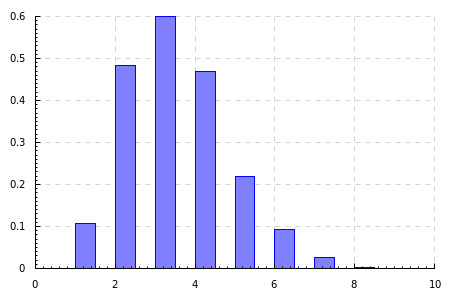

In [14]:
toRenderable . plot . return . histToPlot $ defaultNormedPlotHist
  { _plot_hist_title = "", _plot_hist_values = [real n | (n,s,g) <- samples], _plot_hist_range = Just (0,10), _plot_hist_bins = 20 }

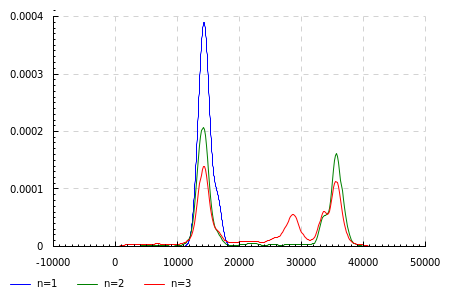

In [15]:
toRenderable $ do
  kdeplot "n=1" 625 $ concat [s | (n,s,g) <- samples, n == 1]
  kdeplot "n=2" 625 $ concat [s | (n,s,g) <- samples, n == 2]
  kdeplot "n=3" 625 $ concat [s | (n,s,g) <- samples, n == 3]

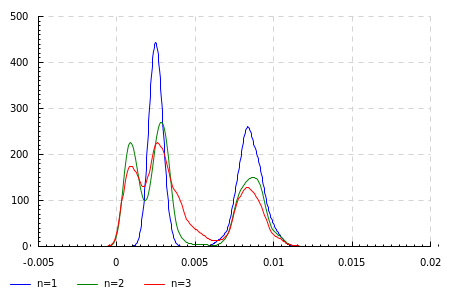

In [16]:
toRenderable $ do
  kdeplot "n=1" 0.0003 $ concat [g | (n,s,g) <- samples, n == 1]
  kdeplot "n=2" 0.0003 $ concat [g | (n,s,g) <- samples, n == 2]
  kdeplot "n=3" 0.0003 $ concat [g | (n,s,g) <- samples, n == 3]

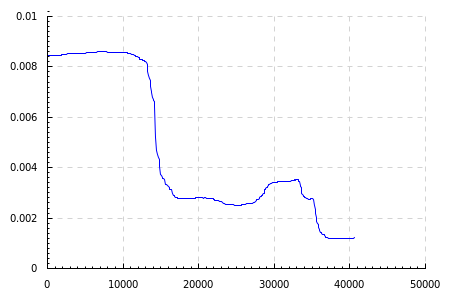

In [17]:
let x = linspace (0, last coalData') 512
    ys = [staircase s g <$> x | (n,s,g) <- samples]
    ymean = mean ys
toRenderable . plot $ line "" [zip x ymean]